<a href="https://colab.research.google.com/github/vifirsanova/ml-course/blob/main/tutorials/machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Механизм внимания**

## Agenda

- **Повторение:** RNN
- **Машинный перевод:** формальное определение задачи
- **Sequence-to-Sequence:** создаем блок кодера и декодера
- **Hands-on:** обучаем Seq2Seq RNN
- **Метрики оценки:** считаем BLEU Score и ROUGE
- **Рефлексия:** ограничения машинного перевода на RNN с точки зрения результата
- **Ключевые проблемы RNN:** взрывающийся и затухающий градиент
- **Attention:** концепция механизма внимания
- **Hands-on:** пишем модель машинного перевода с механизмом внимания

## **Повторение**

1. Назовите главную особенность работы рекуррентных нейросетей.
2. Как это свойство используется в обработке естественного языка?
3. Назовите основные недостатки такой системы

## **Машинный перевод**

1. Сформулируйте определение машинного перевода

##### Спойлер

**Машинный перевод** — это задача автоматического преобразования текста (или речи) с одного естественного языка (источника) на другой (целевой) с сохранением смысла.

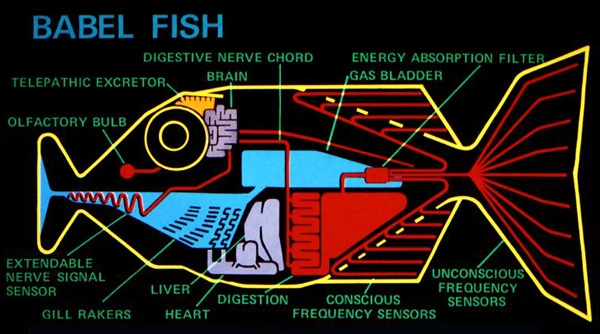

2. Как разработать систему для автоматического перевода речи?

##### Формальное определение задачи

3. Опишите inputs и outputs для решения такой задачи

##### Спойлер

$X$ — множество последовательностей на исходном языке (source language)

$Y$ — множество последовательностей на целевом языке (target language)

**Задача**: построить функцию $f: X \rightarrow Y$

##### T-table

По сути, мы создаем **мэппинг** входной последовательности на выходную:

- входная последовательность $ x = (x_1, ..., x_n) $, где $ x_i $ — один токен исходного текста
- выходная последовательность $ y = (y_1, ..., y_m) $, где $ y_j $ — один токен переведенного текста

**Как построить мэппинг?**

- создаем словарь всех возможных токенов на исходном языке $V_X$
- создаем словарь всех возможных токенов на целевом языке $V_Y$
- допускаем, что любой токен $V_Y$ может быть правдоподобным переводом для любого токена $V_X$
- задаем априорное распределение вероятностей
- максимизируем правдоподобие

**T-table:**

| $V_X$ | $V_Y$ | $P$ | $\rightarrow$ | $V_X$ | $V_Y$ | $P$ |
|-------|-------|-----|---------------|-------|-------|-----|
| $x_i$ | $y_0$ | 0.2 | $\rightarrow$ | $x_i$ | $y_0$ | 0.1 |
| $x_i$ | $y_1$ | 0.2 | $\rightarrow$ | $x_i$ | $y_1$ | 0.1 |
| $x_i$ | $y_2$ | 0.2 | $\rightarrow$ | $x_i$ | $y_2$ | 0.1 |
| $x_i$ | $y_3$ | 0.2 | $\rightarrow$ | $x_i$ | $y_3$ | 0.3 |
| $x_i$ | $y_4$ | 0.2 | $\rightarrow$ | $x_i$ | $y_4$ | 0.4 |

Например:

| $V_X$ | $V_Y$ | $P$ | $\rightarrow$ | $V_X$ | $V_Y$ | $P$ |
|-------|-------|-----|---------------|-------|-------|-----|
| мопс  | tomato | 0.2 | $\rightarrow$ | мопс  | tomato | 0.1 |
| мопс  | app | 0.2 | $\rightarrow$ | мопс  | app | 0.1 |
| мопс  | table | 0.2 | $\rightarrow$ | мопс  | table | 0.1 |
| мопс  | dog | 0.2 | $\rightarrow$ | мопс  | dog | 0.3 |
| мопс  | dog | 0.2 | $\rightarrow$ | мопс  | pug | 0.4 |

Перевод для отдельного токена будет задаваться вектором вида:

$x_i: [y_0, y_2 ... y_n]$

Например:

$мопс: [0.1, 0.1, 0.1, 0.3, 0.4]$

Для выбора наиболее правдоподобного варианта перевода мы испольуем аргумент максимизации:

$f(x) = \arg\max_{y \in \mathcal{Y}} P(y \mid x)$  

По сути, достаем из таблицы вероятностных распределений значение с максимальным коэффициентом правдоподобия.

4. Чего не хватает в этой модели? Какие условия необходимо соблюсти для генерации реалистичного варианта перевода?

##### Спойлер

**Вероятностная модель машинного перевода** включает два компонента:

- условная вероятность $ P(y|x) $
  - составляем T-table: подбираем правдоподобные исходы для $y$ при данном $x$, т.е. вычсляем правдоподобные варианты перевода для данного токена
- вероятность $ P(y) $
  - ищем правдоподобные сочетания символов из словаря $V_Y$, чтобы получить текст перевода, который воспринимается естественно на целевом языке

##### Формальное определение задачи в рамках **теоремы Байеса**:

- машинный перевод - это поиск наиболее вероятного перевода $ y $ при данном исходном $ x $:  

$$
y^* = \arg\max_{y} P(y|x)
$$

- $y^*$ - оптимальный (наилучший) перевод среди всех возможных кандидатов $y$

По **теореме Байеса**, условная вероятность раскладывается как:  

$$
P(y|x) = \frac{P(x|y) \cdot P(y)}{P(x)}
$$

$ P(x) $ не зависит от $ y $, его можно опустить. Получаем следующую модель перевода:  

$$
y^* = \arg\max_{y} P(x|y) \cdot P(y)
$$

- $ P(x|y) $ — **модель перевода** (translation model) ищет соответствия между исходными и целевыми токенами
- $ P(y) $ — **языковая модель** (language model) моделирует возможные сочетания токенов в целевом языке, обеспечивает естественность и грамотность целевого, результирующего текста

Такой подход применяется в **статистическом машинном переводе**: фактически мы создаем 2 модели и вычисляем совместную вероятность для двух событий ([данные последовательности токенов эквивалентны по смыслу в языках $X$ и $Y$] * [результирующая последовательность в языке $Y$ является правдоподобной в данном языке])

5. Почему такая модель не является оптимальным решением для машинного перевода?

## **Sequence-to-Sequence**

**Интуиция для нейросетевой модели:** end-to-end модель принимает на вход исходную последовательность и продуцирует целевую последовательность

**Реализация:** создаем блок кодера и декодера

- **Кодер**: класс, который создает мэппинг, векторное представление исхдного текста
- **Декодер**: класс, который "дешифровывает" созданный мэппинг. Фактически, генерирует новый текст на основе левого контекста (левый контекст - последовательность векторов, репрезентирующая исходную последовательность)

**Формальное представление**

$$
Encoder: h_t = f_w(x_t, h_{t-1})
$$

- $h_t$ - текущий шаг вычислений
- $f_w$ - функция, параметризированная вычисленными весами (веса репрезентируют силу связи между токенами исходными целевыми токенами т.о., чтобы модель могла сгенерировать правдоподобный перевод)
- $x_t$ - токен, который картируется на текущем шаге (например, "Меня зовут **Джон**)
- $h_{t-1}$ - результат вычислений на предыдущем шаге (например, мэппинг текста "Меня зовут")

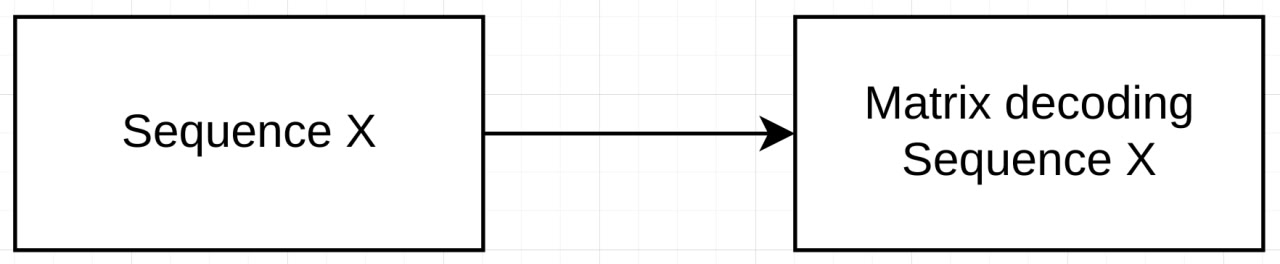

Финальное выходное состояние представляет собой контекстный вектор $c$, который подается на вход декодеру.

$$
c = h_t
$$

Контекстный вектор равен результату вычислений на выходном состоянии кодера.

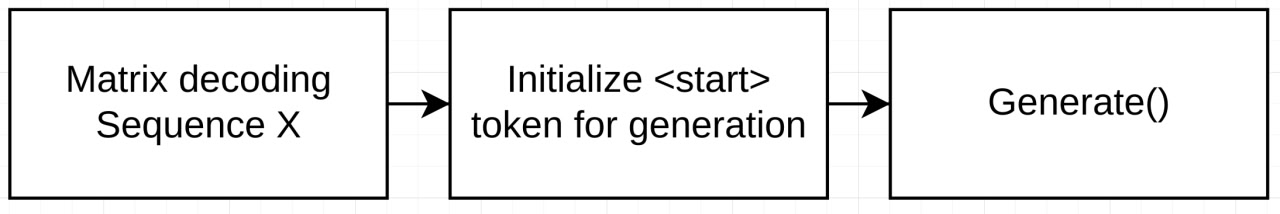

Каждый следующий токен обуславливается предыдущим.

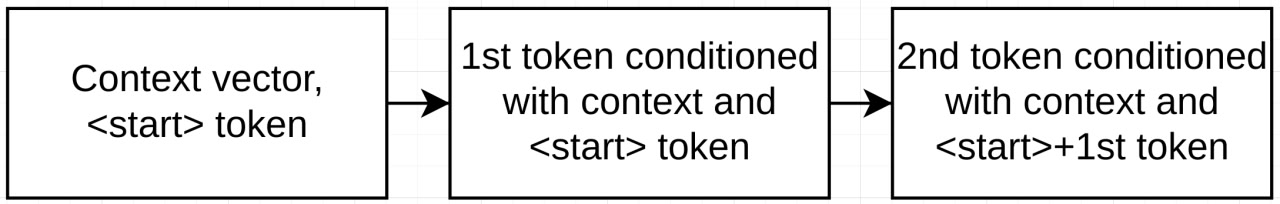

$$
Decoder: s_t = g(y_{t-1}, s_{t-1}, c)
$$

- $s_t$ - текущее состояние декодера
- $g$ - функция для генерации текста
- $y_{t-1}$ - корректный предшествующий токен из золотой выборки, используется для обуславливания генерации методов teacher forcing
- $s_{t-1}$ - предшествующий сгенерированный токен
- $c$ - контекстный вектор

In [61]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Пример мини-датасета (англ -> рус)
sentences = [
    ("Hello world", "Привет мир"),
    ("How are you", "Как дела"),
]

# Создаем словари
src_vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
tgt_vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2}

# Заполняем словари токенами
for en, ru in sentences:
    for word in en.lower().split():
        if word not in src_vocab:
            src_vocab[word] = len(src_vocab)
    for word in ru.lower().split():
        if word not in tgt_vocab:
            tgt_vocab[word] = len(tgt_vocab)

# Размеры словарей
src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)

# Вывод словарей
print('Словарь V_X')
print(src_vocab)
print('Словарь V_Y')
print(tgt_vocab)

Словарь V_X
{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'hello': 3, 'world': 4, 'how': 5, 'are': 6, 'you': 7}
Словарь V_Y
{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'привет': 3, 'мир': 4, 'как': 5, 'дела': 6}


In [63]:
class TranslationDataset(Dataset):
    def __init__(self, sentences, src_vocab, tgt_vocab):
        self.data = []
        for en, ru in sentences:
            # Добавляем <sos> и <eos>, преобразуем слова в индексы
            src_ids = [src_vocab["<sos>"]] + [src_vocab[w] for w in en.lower().split()] + [src_vocab["<eos>"]]
            tgt_ids = [tgt_vocab["<sos>"]] + [tgt_vocab[w] for w in ru.lower().split()] + [tgt_vocab["<eos>"]]
            self.data.append((torch.tensor(src_ids), torch.tensor(tgt_ids)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Формирование словаря
dataset = TranslationDataset(sentences, src_vocab, tgt_vocab)

# Вывод результата
print('Закодированный словарь')
print(dataset.data)

[(tensor([1, 3, 4, 2]), tensor([1, 3, 4, 2])), (tensor([1, 5, 6, 7, 2]), tensor([1, 5, 6, 2]))]


**Магические методы** с двойными подчеркиваниями в Python  определяют поведение класса

Например,

- через них мы указываем объекты, которые инициализирует данный класс (`__init__`)
- прописываем, по какому элементу, образующему данный класс, будет выводится длина объекта через `len()` (`__len__`)
- определяем "характер" индексации объекта с `[]` (`__getitem__`)

Здесь мы используем три таких метода:

1. `__init__` – конструктор объекта

Вызывается **при создании экземпляра класса**. Он инициализирует объект, устанавливая начальные значения атрибутов

In [65]:
dataset.data

[(tensor([1, 3, 4, 2]), tensor([1, 3, 4, 2])),
 (tensor([1, 5, 6, 7, 2]), tensor([1, 5, 6, 2]))]


2. `__len__` – длина объекта

Вызывается функцией `len()`. Возвращает длину указанного в `__len__` объекта

In [67]:
len(dataset) == len(dataset.data)

True

3. `__getitem__` – доступ по индексу/ключу

Позволяет объекту поддерживать **индексацию** (`obj[key]`). Вызывается при обращении к объекту через квадратные скобки. Индексация производится по объекту, указанному в `__getitem__` через `return`

Поддерживает **срезы** (`my_list[1:3]`) и другие варианты индексации.

In [68]:
dataset[0]

(tensor([1, 3, 4, 2]), tensor([1, 3, 4, 2]))

In [69]:
dataset[0][0]

tensor([1, 3, 4, 2])

In [76]:
# Функция для добавления паддинга
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    # Дополняем последовательности до максимальной длины в батче
    src_padded = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_padded = torch.nn.utils.rnn.pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_padded, tgt_padded

# Используем collate_fn в DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

`zip()` - это итератор, который "упаковывает" элементы из нескольких итерируемых объектов (списков, кортежей и т. д.) в кортежи:

In [80]:
names = ["Alice", "Bob", "Charlie"]
ages = [25, 30, 35]

zipped = list(zip(names, ages))
print(zipped)

[('Alice', 25), ('Bob', 30), ('Charlie', 35)]


Оператор `*` производит обратную операцию:

In [82]:
list(zip(*zipped))

[('Alice', 'Bob', 'Charlie'), (25, 30, 35)]

**Почему мы используем итераторы?**

- Итераторы не загружают все данные в память сразу, а генерируют элементы по очереди. Это удобно при работе с:

    - Большими файлами (стриминг, построчное чтение)

    - Бесконечными последовательностями (генерация чисел Фибоначчи нам всем очень нужна)

    - Потоковая обработка данных

In [54]:
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.src_embed = nn.Embedding(src_vocab_size, embed_dim)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, embed_dim)
        self.fc_out = nn.Linear(hidden_dim, tgt_vocab_size)

    def forward(self, src, tgt):
        # Энкодер
        src_embedded = self.src_embed(src)
        _, (hidden, cell) = self.encoder(src_embedded)

        # Декодер
        tgt_embedded = self.tgt_embed(tgt)
        outputs, _ = self.decoder(tgt_embedded, (hidden, cell))
        return self.fc_out(outputs)

model = Seq2Seq(src_vocab_size, tgt_vocab_size, embed_dim=64, hidden_dim=128)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Игнорируем <pad>
optimizer = torch.optim.Adam(model.parameters())

In [55]:
for epoch in range(100):
    for src, tgt in dataloader:
        optimizer.zero_grad()
        # Исключаем <eos> из входа декодера
        output = model(src, tgt[:, :-1])
        # Сравниваем с tgt[:, 1:], игнорируя <pad> (0)
        loss = criterion(output.reshape(-1, tgt_vocab_size), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()

In [56]:
def translate(model, src_sentence, src_vocab, tgt_vocab, max_len=20):
    model.eval()

    # 1. Подготовка исходного предложения
    src_words = src_sentence.lower().split()

    # Преобразуем слова в индексы с обработкой неизвестных слов
    src_ids = [src_vocab.get("<sos>", 1)]  # Начинаем с <sos>
    for word in src_words:
        src_ids.append(src_vocab.get(word, src_vocab.get("<unk>", 3)))  # 3 - индекс для неизвестных слов

    src_ids.append(src_vocab.get("<eos>", 2))  # Добавляем <eos>

    # 2. Проверка на пустой ввод
    if len(src_ids) == 2:  # Только <sos> и <eos>
        return ""

    # 3. Преобразуем в тензор
    src_tensor = torch.tensor(src_ids).unsqueeze(0).to(next(model.parameters()).device)

    # 4. Словарь для обратного преобразования
    id_to_word = {v: k for k, v in tgt_vocab.items()}

    with torch.no_grad():
        # Энкодер
        src_embedded = model.src_embed(src_tensor)
        _, (hidden, cell) = model.encoder(src_embedded)

        # Декодер
        tgt_ids = [tgt_vocab.get("<sos>", 1)]
        for _ in range(max_len):
            tgt_tensor = torch.tensor([tgt_ids[-1]]).unsqueeze(0).to(src_tensor.device)
            tgt_embedded = model.tgt_embed(tgt_tensor)
            output, (hidden, cell) = model.decoder(tgt_embedded, (hidden, cell))

            # Берем наиболее вероятный следующий токен
            next_word_id = output.argmax(-1).item()

            # Проверка на выход за границы словаря
            if next_word_id >= len(tgt_vocab):
                next_word_id = tgt_vocab.get("<unk>", 3)

            tgt_ids.append(next_word_id)

            # Остановка при достижении <eos>
            if next_word_id == tgt_vocab.get("<eos>", 2):
                break

    # 5. Преобразуем индексы в слова
    translated_words = []
    for idx in tgt_ids[1:-1]:  # Пропускаем <sos> и <eos>
        if idx in id_to_word:
            translated_words.append(id_to_word[idx])
        else:
            translated_words.append("<unk>")

    return " ".join(translated_words)

In [58]:
# Тестирование
test_sentence = "Hello world"
print(f"Input: {test_sentence}")
print(f"Translation: {translate(model, test_sentence, src_vocab, tgt_vocab)}")

Input: Hello world
Translation: привет привет привет привет привет привет привет привет привет привет привет привет привет привет привет привет привет привет привет


## **Метрики оценки**

6. Как оценить качество машинного перевода?

#### Спойлер

**BLEU (Bilingual Evaluation Understudy)**  
1. Токенизация: разбиение кандидата (результат генерации) и эталонных переводов на токены.  

2. Вычисление штрафа за краткость (Brevity Penalty, BP): если длина кандидата меньше ближайшего эталона → применяется штраф.  

3. Считаются совпадения n-грамм кандидата с эталонами.  

4. Для каждой n-граммы считается точность (Precision), при этом учитывается не более, чем максимальное вхождение данной n-граммы в эталоне (избыточные повторения n-грамм усекаются).

5. Результат: средняя точность x BP.

#### Работа с библиотеками

In [108]:
from nltk.translate.bleu_score import corpus_bleu

# BLEU для корпуса
references = [[['this', 'is', 'a', 'test'], ['that', 'is', 'a', 'test']]]
candidates = [['this', 'is', 'a', 'test']]
corpus_score = corpus_bleu(references, candidates)
print(f"BLEU для корпуса: {corpus_score}")

BLEU для корпуса: 1.0


Метрика ROUGE основана на полноте (Recall) и чаще используется для оценки качества суммаризации

In [109]:
!pip install rouge -q

from rouge import Rouge

# Пример использования
rouge = Rouge()

candidate = "a beautiful cat is on the mat"
references = "the cat is on the mat"

scores = rouge.get_scores(candidate, references, avg=True)
print(f"ROUGE scores: {scores}")

ROUGE scores: {'rouge-1': {'r': 1.0, 'p': 0.7142857142857143, 'f': 0.8333333284722222}, 'rouge-2': {'r': 0.8, 'p': 0.6666666666666666, 'f': 0.7272727223140496}, 'rouge-l': {'r': 1.0, 'p': 0.7142857142857143, 'f': 0.8333333284722222}}


**Рефлексия:**

- ограничения машинного перевода на RNN с точки зрения результата

- взрывающийся и затухающий градиент

**Выравнивание в статистическом машинном переводе**

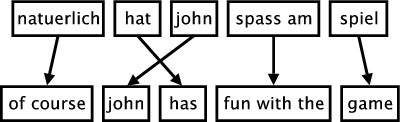

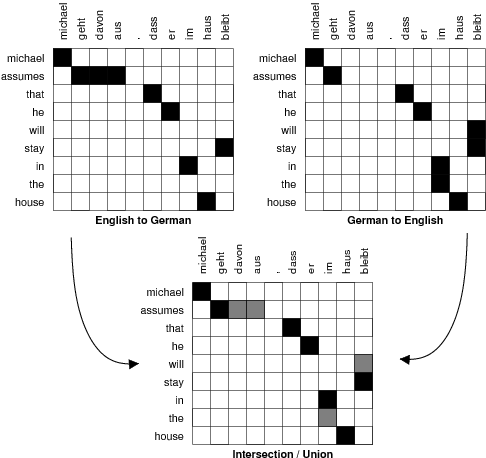

Скрытая переменная a:

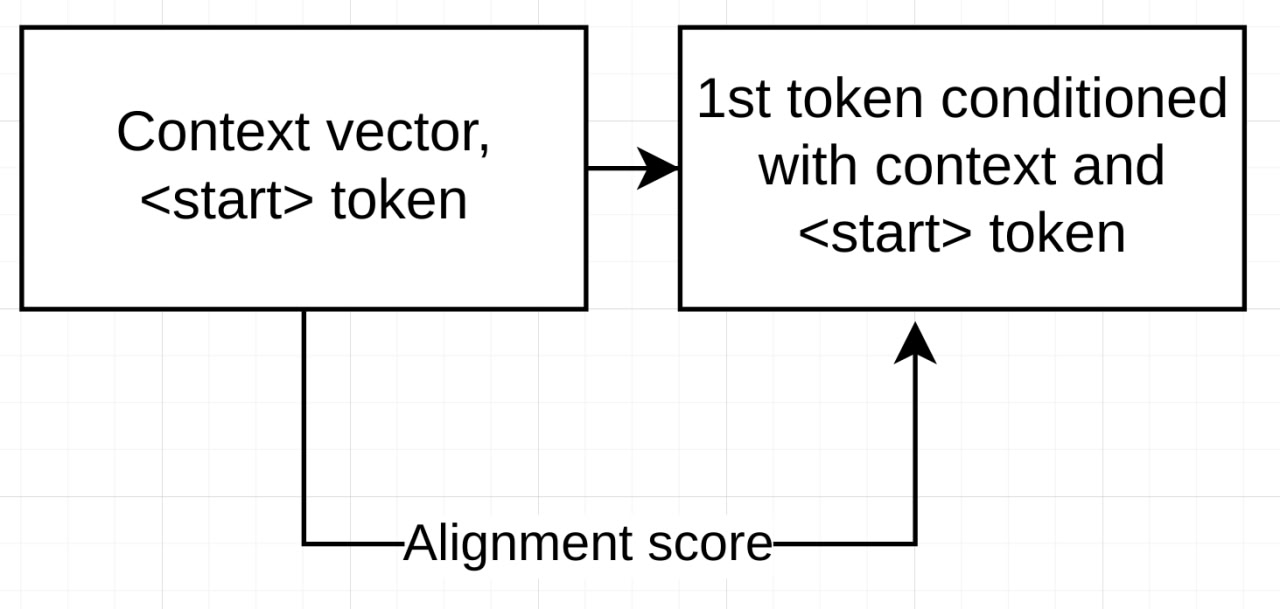

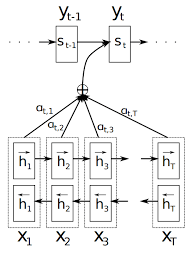

8. Как устроен слой внимания в TF?

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention